In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set(style="whitegrid")
np.set_printoptions(precision=4)

# Problem Set 4

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**

## Introduction

Lab 7 was all about statistical inference, specifically, Bayesian statistical inference. 

**You *must* use Bayesian inference on four  problems for this Problem Set. Specifically, you must use the Non-Parametric Bootstrap to estimate posterior distributions.** We do not want to see p-values or confidence intervals **at all.** No Frequentist inference.

The problems are designed to get progressively more difficult.

* <a href="#q1">Problem 1<a>
* <a href="#q2">Problem 2<a>
* <a href="#q3">Problem 3<a>
* <a href="#q4">Problem 4<a> 
  
You can add more cells (markdown/code) but do not change the labeling or ordering of the existing cells.

<a id="q1"></a>
## Problem 1
---


You recently surveyed your customers in a marketing campaign to determine if they would be willing to switch from emails to text alerts. You have previously broken your customers into two groups "Beer" lovers and "Wine" lovers.

The results are below:

```
                        Response
                        No   Yes  Total
       Segments    Wine  18  82  100
                   Beer  53  47  100
                   Total 71 129  200
```
As you analyze the data, you note that the overall percentage of customers who would be willing to get text messages instead of 64.5% (129/200). Engineering and Marketing have established that in order for the switch (from email to SMS texts) to be cost effective, the proportion of customers will to switch had to be at least 60%.

Because 64.5% is greater than 60.0%, the results of the survey are interesting ("meaningful") but how believable are they?


### Problem 1.1

Let $\theta$ be the percent of the total that responded yes, estimate the posterior distribution of P($\theta$|Data).

We can bootstrap this data by modeling it as a Bernoulli process. As Lab 7 says:

> We want to know all the values that are supported by the data we collected and the degree to which they are supported...how confident we are in them. This is basically what we get when we calculate a posterior distribution over $\theta$ based on the data.

To do this, we will create the data seen in the table above, and carry out non-parametric bootstrap to estimate the posterior of $P(\theta | data)$.

1. Create the data seen in the table

In [3]:
drinkers = np.array(([0]*18 + [0]*53 + [1]*82 + [1]*47))

2. Set up and run a bootstrap

In [4]:
def bootstrap_sample(data, f, n=100):
    m = len(data)
    return np.array(
        [f(np.random.choice(data, len(data), replace=True)) for _ in range(n)]
    )

In [5]:
np.random.seed(100)
drinkers_posterior = bootstrap_sample(drinkers, np.mean, 500)

We have now estimated the posterior distribution; let's plot it.

In [6]:
def plot_posterior(posterior):
    figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.

    axes = figure.add_subplot(1, 1, 1)

    axes.hist( posterior, density = True)
    axes.set_ylabel( "Density")
    axes.set_xlabel( "$\hat{\\theta}$")
    axes.set_title( "Posterior Distribution of $\hat{\\theta}$")

    plt.show()
    plt.close()

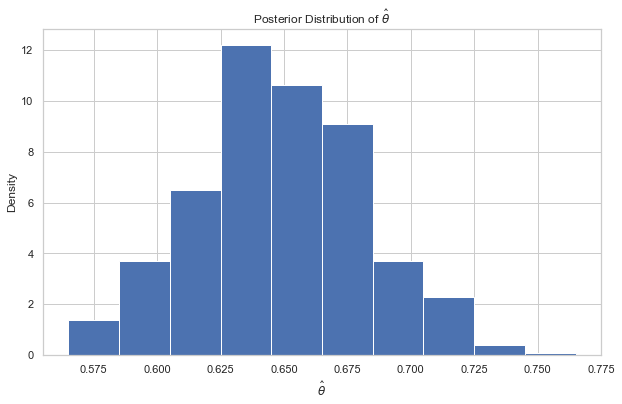

In [7]:
plot_posterior(drinkers_posterior)

This posterior certainly has a normal shape. It extends from about 0.575 to 0.75. Let's get some more information from it.

### Problem 1.2

What is the 95% credible interval for $\theta$? Interpret it.

To calculate the 95% Bayesian Credible Interval (BCI), we can go straight to the data

In [8]:
stats.mstats.mquantiles(drinkers_posterior, [0.025, 0.975])

array([0.5795, 0.7105])

There is a 95% percent chance that the proportion of customers who are willing to switch to text messages, $\theta$, is between 57.95% and 71.05%

### Problem 1.3

Because the threshold was set at 60%, any percentage 60% or greater is "practically equivalent" (we don't care how far above 60% it is as long as it's at least 60%). What is the probability of this ROPE? Interpret your result.

In [9]:
(drinkers_posterior > 0.60).mean()

0.898

The probability that the data supports this ROPE (60% or greater) is 89.8%. 

### Problem 1.4

Even though the overall results appear to be satisfactory, Marketing is concerned we may lose Beer drinkers (ie, they believe the 53% "no" is meaningful). To what degree is the result believable for Beer drinkers. Discuss your results.

We are being asked to look more specifically at the beer drinkers, so let's create a dataset just for them.

In [10]:
beer_drinkers = np.array(([0]*53 + [1]*47))

Now, we can carry out non-parametric bootstrapping to estimate the posterior, and decide to what degree the result for beer drinkers is believable.

In [11]:
np.random.seed(100)
beer_posterior = bootstrap_sample(beer_drinkers, np.mean, 500)

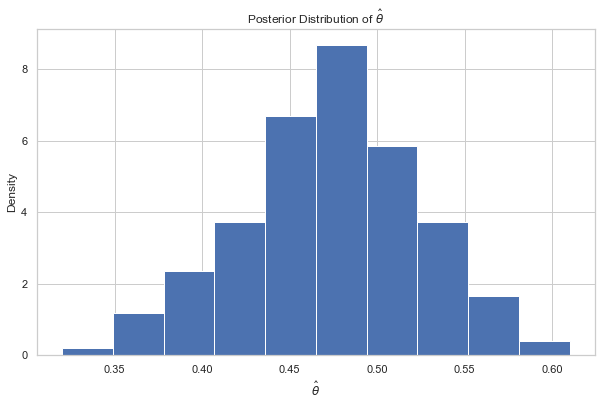

In [12]:
plot_posterior(beer_posterior)

We now have an estimated posterior of responses from the beer drinkers, and can start asking questions. For instance, what is the 95% percent BCI for this data?

In [13]:
stats.mstats.mquantiles(beer_posterior, [0.025, 0.975])

array([0.37, 0.57])

There is a 95% probability that the true "yes" rate for beer drinkers is between 37% and 57%. 

Let's also calculate it in terms of our ROPE of 60% or higher

In [14]:
(beer_posterior > 0.60).mean()

0.002

There is only a 0.2% probability that the beer drinkers actually have a "yes" rate of $\ge$60%, so Marketing probably should be concerned about losing beer drinkers.

<a id="q2"></a>
## Problem 2

---

Fifteen volunteers were put on the Supper Dooper Human Kibble Diet(tm) for a month. They were weighed at the start and again after 30 days. Thus you can take `data1["start"][0]` and `data1["end"][0]` to be the weight of the same person with the first measurement at the start and the second measurement at the end of 30 days, etc. Thus, the people in "start" and the people in "end" *are* the same.

The makers of The Super Dooper Human Kibble Diet(tm) are anxious to see the results of this study because they are planning to offer a money back guarantee of "Lose at least 10 Pounds in 30 days or your money back!"

First, make very sure you're clear on what this question is really asking...there's two ways to interpret it and only one is right. 

Based on the data, answer the following questions:

In [15]:
data2 = {}
data2["start"] = [129, 174, 200, 229, 205, 133, 143, 222, 161, 201, 194, 181, 185, 126, 212]
data2["end"]   = [134, 171, 190, 227, 206, 130, 129, 218, 138, 187, 191, 177, 183, 124, 205]

### Problem 2.1

What is the probability that Super Dooper Human Kibble can make this claim (ie, how believable is it)?

Super Dooper Human Kibble Diet wants to claim that you will lose at least 10 pounds in 30 days. Hence, to carry out bootstraping on this data, what we need to do is first take the difference, and then bootstrap the differences. If we bootstrap the before and after weights, someone who satrted at 200lbs might be matched with someone who started at 110lbs, and the difference would make no sense. What we're really interested in is the differences. 

In [16]:
weights_diff = np.array(data2["start"]) - np.array(data2["end"])

In [17]:
weights_posterior = bootstrap_sample(weights_diff, np.mean, n = 1_000)

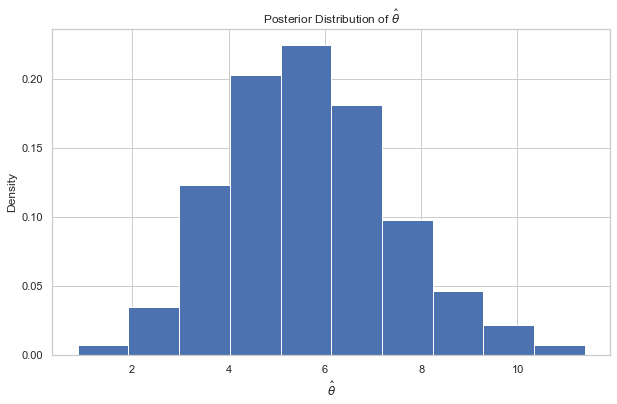

In [18]:
plot_posterior(weights_posterior)

We have now generated a posterior of the weight differences. Now that we have this data, we can start to answer more detailed questions, like what is the probability that they can make this claim?

In [19]:
(weights_posterior >= 10).mean()

0.014

There is a 1.4% probability that the Super Dooper Human Kibble Diet (TM) will make you lose 10 pounds in 30 days. In other words, it is not a very believable claim.

### Problem 2.2

How likely is it that the diet doesn't work at all (zero weight loss? How would you define that? Assume that your weight fluctuates about 5 pounds around your "true" weight.

Assuming that the phrase "fluctuates about 5 pounds around your true weight" means true weight plus or minus 2.5 pounds. This means that zero weight loss means that the difference has an absolute value of 2.5. Hence, we can see what percent of cases there are with an absolute difference within 2.5 pounds.

In [20]:
(np.abs(weights_posterior) <= 2.5).mean()

0.023

Assuming that measured weight is true weight plus or minus 2.5 pounds pounds (for a total of 5 pound fluctuation), there is a 2.3% chance that the diet causes no weight loss.

### Problem 2.3

How likely is it that you actually gain weight under the diet? Again, assume that your weight fluctuates about 5 pounds around your your "true" weight (both over and under, evenly).

Using the same definition as in 2.2, we want to know what is the probability that the difference is $\le -2.5$ pounds

In [21]:
(weights_posterior <= -2.5).mean()

0.0

The probability that the diet causes you to gain weight is negligibly small. 

### Problem 2.4

The Lawyers and Accountants have re-crunched the numbers and the legal terms. If the diet doesn't "work" for 10 pounds, what value (threshold) will the diet work for at least 66% of the time? That is, what value can we substitute for "10 pounds" in our money back guarantee that will be true at least 66% of the time?

To answer this question, let's look at the distribution of our posterior again

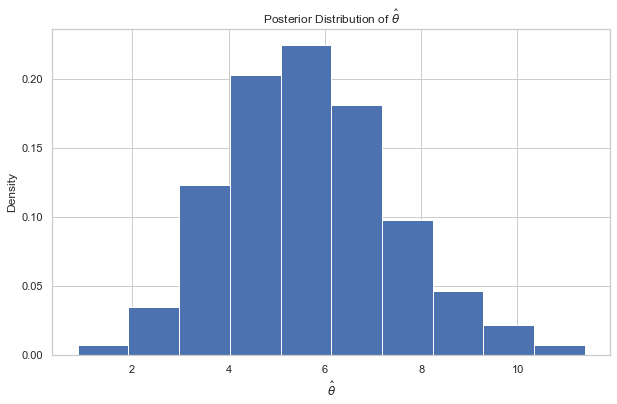

In [22]:
plot_posterior(weights_posterior)

The definition of "work" for a diet means losing at *least* X amount. So in this case, we want the value and everything to the right to make up 66%. To get this, we ask for the 34th percentile, which gives us 66% of the data to the right.

In [23]:
stats.mstats.mquantiles(weights_posterior, [0.34])

array([4.8667])

We should substitue 4.87 pounds as the new money back guarantee. The diet should cause you to lose at least 4.87 pounds, 66% of the time. 

<a id="q3"></a>
## Problem 3

---

The Data Science Team at Acme Company has developed a new engagement algorithm they believe will be more effective than the current one. To test the new algorithm they conducted an A/B test for two groups of 100 users each, selected at random, over a week. 

In order for the change to be cost effective, visitors need to spend at least 5 minutes more per week on the website under the new algorithm.

The data is provided below (the people in "old" and the people in "new" are *not* the same).

In [24]:
data3 = {}
data3["old"] = [161, 184, 138, 178, 188, 175, 195, 214, 183, 184, 195, 196, 150, 206, 185, 202, 216, 186, 153, 174, 217, 217, 178, 172, 205, 192, 172, 222, 197, 174, 163, 206, 176, 176, 230, 202, 267, 186, 190, 200, 182, 160, 225, 185, 205, 213, 189, 171, 166, 239, 170, 198, 198, 198, 211, 194, 197, 212, 194, 236, 163, 218, 221, 189, 182, 182, 202, 172, 165, 180, 214, 186, 191, 179, 191, 204, 209, 212, 141, 188, 193, 192, 185, 199, 144, 146, 231, 201, 177, 191, 197, 182, 174, 231, 202, 195, 161, 187, 181, 186]
data3["new"] = [196, 245, 196, 243, 181, 161, 173, 151, 148, 195, 247, 164, 167, 234, 200, 215, 204, 190, 148, 127, 174, 135, 231, 199, 125, 138, 140, 206, 139, 177, 260, 231, 173, 172, 178, 224, 186, 115, 144, 222, 189, 107, 239, 124, 216, 169, 212, 262, 145, 221, 179, 192, 142, 232, 171, 233, 287, 216, 188, 156, 169, 238, 128, 155, 202, 174, 229, 198, 192, 169, 156, 238, 178, 220, 177, 191, 234, 251, 166, 123, 144, 127, 203, 230, 203, 188, 185, 255, 239, 227, 173, 196, 208, 236, 194, 204, 217, 252, 169, 166]

Based on the data, fully analyze the A/B test. You will be graded on the completeness and thoroughness of your analysis. You should make sure you include:

1. BCI
2. ROPE
3. ?

### Problem 3.1

Calculate the 95% BCI and interpret it.

To begin, we need to create a posterior estimate. We will do this with the non-paramentric bootstrap

In [25]:
old_posterior = bootstrap_sample(data3["old"], np.mean, 1_000)
new_posterior = bootstrap_sample(data3["new"], np.mean, 1_000)
difference_posterior = old_posterior - new_posterior

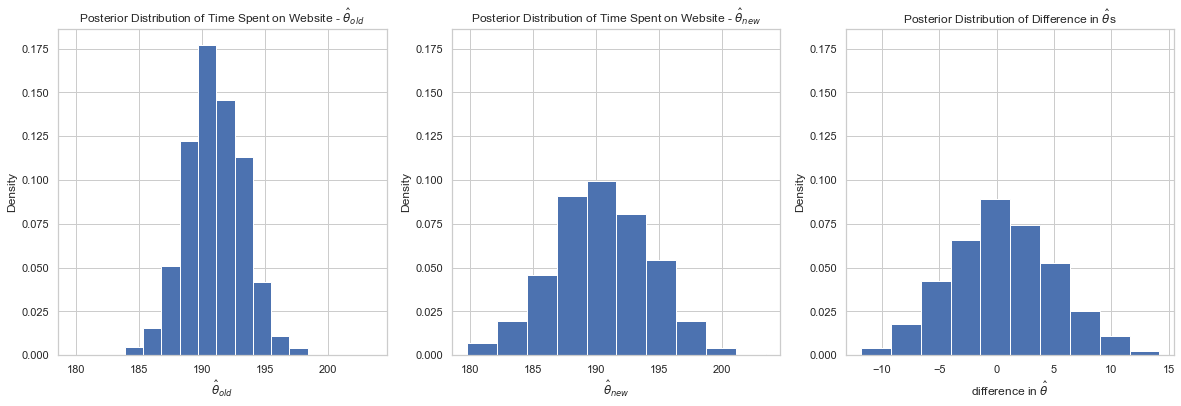

In [26]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

ax1 = figure.add_subplot(1, 3, 1)

ax1.hist( old_posterior, density=True)
ax1.set_ylabel( "Density")
ax1.set_xlabel( "$\hat{\\theta}_{old}$")
ax1.set_title( "Posterior Distribution of Time Spent on Website - $\hat{\\theta}_{old}$ ")

ax2 = figure.add_subplot(1, 3, 2, sharex = ax1, sharey = ax1)
ax2.hist( new_posterior, density=True)
ax2.set_ylabel( "Density")
ax2.set_xlabel( "$\hat{\\theta}_{new}$")
ax2.set_title( "Posterior Distribution of Time Spent on Website - $\hat{\\theta}_{new}$")

ax3 = figure.add_subplot(1, 3, 3, sharey = ax1)
ax3.hist( difference_posterior, density=True)
ax3.set_ylabel( "Density")
ax3.set_xlabel( "difference in $\hat{\\theta}$")
ax3.set_title( "Posterior Distribution of Difference in $\hat{\\theta}$s")

plt.show()
plt.close()

From the plots here, we can start to get some idea of how the two posteriors interact. The two seem to have similar means. However, the new algorithm seems to have a greater spread of data than the old algorithm. This does not bode well, since the whole point of the new algorithm is to get more people to spend more time on the website. 

Now let's investigate the 95% BCIs for all three distributions

In [27]:
print("95% BCI for old alorithm's theta:", stats.mstats.mquantiles(old_posterior       , [0.025, 0.975]))
print("95% BCI for new alorithm's theta:", stats.mstats.mquantiles(new_posterior       , [0.025, 0.975]))
print("95% BCI for difference:"          , stats.mstats.mquantiles(difference_posterior, [0.025, 0.975]))

95% BCI for old alorithm's theta: [186.4862 195.45  ]
95% BCI for new alorithm's theta: [183.1645 197.8995]
95% BCI for difference: [-7.8176  9.6879]


This tells us the following:

- With the old algorithm, there is a 95% chance a visitor spends between 186.4 and 195.4 minutes per week on the website
- With the new algorithm, there is a 95% chance a visitor spends between 182.9 and 197.2 minutes per week on the website
- There is a 95% probability that the difference between the time spent per week with the old and new algorithm is between -7.6 minutes and 9.5 minutes

### Problem 3.2

Calculate the ROPE and interpret it.

With the requirement of

> In order for the change to be cost effective, visitors need to spend at least 5 minutes more per week on the website under the new algorithm.

I would say that a reasonable ROPE is the region of five or more minutes spent on the site. Since our difference is old - new, we are actually looking for times of -5 or less

In [28]:
(difference_posterior <= -5).mean()

0.116

There is only an 11% probability that the new algorithm leads to 5 minutes or more per week on the website. This is not a great result. I would not suggest putting the new algorithm into use

### Problem 3.3

Pick an interesting inferential question for the data and answer it.

We have looked at 95% BCIs, and the probability that the new algorithm is cost effective. Now, let's look at how likely a user is to spend *any* more time on the website becuase of the new algorithm, and the opposite: how likely is a user to spend *less* time on the website due to the new algorithm.

Let's start with probability of spending more time. Remember that because our difference was calculated as old - new, more time means a negative difference

In [29]:
(difference_posterior < 0).mean()

0.443

There is a 45.2% probability that a visitor will spend *more* time on the website with the new algorithm; definitely not a good result.

Now let's see probability of spending less time:

In [30]:
(difference_posterior > 0).mean()

0.556

There is a 54.8% probability that a visitor will spend *less* time on the website with the new algorithm. These three sets of numbers:
- 95% BCIs
- ROPE calculation
- Probability of spending more or less time

paint a fairly clear picture of the effects of the new algorithm: *it increases the variability in user's time on the site, and generally decreases their probability of staying for longer*.

<a id="q4"></a>
## Problem 4
---

So far we have talked about the Non-Parametric Bootstrap. In this question, you will use the Parametric Bootstrap to solve a problem in Bayesian inference when you don't have the original data.

We could use the Normal Distribution for this problem because test scores are likely normally distributed. However, we run into a problem when doing simulations because we're likely to generate test scores outside the range 0-100.

We can use the Truncated Normal Distribution (`truncnorm`) instead. From the scipy docs truncnorm page: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html

"The standard form of this distribution is a standard normal truncated to the range [a, b] — notice that a and b are defined over the domain of the standard normal. To convert clip values for a specific mean and standard deviation, use:

a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

"

Plus further clarification on a and b from https://stackoverflow.com/questions/18441779/how-to-specify-upper-and-lower-limits-when-using-numpy-random-normal

a, b = (lower - mu) / sigma, (upper - mu) / sigma

> "Within a school district, students were randomly assigned to one of two Math teachers - Mrs. Smith and Mrs. Jones. After the assignment, Mrs. Smith had 30 students, and Mrs. Jones had 25 students.
>
> At the end of the year, each class took the same standardized test. Mrs. Smith's students had an average test score of 78, with a standard deviation of 10; and Mrs. Jones' students had an average test score of 85, with a standard deviation of 15.
>
> What is the probability that Mrs. Smith and Mrs. Jones are equally effective teachers."

The method is to take M random samples of size N from the parameterized distribution. Use M=100 and the respective class sizes as N.

### Problem 4.1

Define what "equally effective might mean". This circumscribes what is "meaningful".

"Equally effective" is a rather subjective metric, only made harder to define by the fact that a truncated normal distribution has both a "location" and a "scale". Is a teacher with a higher "location" but larger "scale", better than one with a lower "location" and smaller "scale"? There isn't a single obvious answer that comes to mind; it's not that different from asking "how do we, as a society, want our children to learn and move forward in school?". 

Despite this ambiguity, let's measure a teacher's "effectiveness" by the percent of students that "pass" the test. We could define "passing" as having a score equal to or greater than some predetermined number. Another method of saying which students passed is by saying something like "the bottom 10% have failed". (This is certainly a method that I favored when class averages were below 50). However, in the interest of making this problem easier for myself, I will choose the first method, and imagine that the teachers have defined the following:

- $\ge 90$: A
- $\ge 80$: B
- $\ge 70$: C
- $\ge 60$: D
- $< 60$: FAIL

With this definition, **two teachers that are "equally effective" means approximately the same percent of their students do not fail.** We will say that "approximately the same percent" means within 5% of eachother. 

Hence, **two teachers that are "equally effective" means that the difference of the percent of students who pass is less than or equal to 5%.**

### Problem 4.2

Now determine if it is *believable*.

To parameterize a truncated normal distribution, we need the following:

- upper bound: 100
- lower bound: 0
- location: $\mu$
- scale: $\sigma$
- $a = \frac{lower\_bound - \mu}{\sigma}$
- $b = \frac{upper\_bound - \mu}{\sigma}$

where $\mu_{smith} = 78$, $\sigma_{smith} = 10$, and $\mu_{jones} = 85$, $\sigma_{jones} = 15$

In [31]:
lower  , upper   = 0 , 100
μ_smith, σ_smith = 78, 10
μ_jones, σ_jones = 85, 15

smith_class_size = 30
jones_class_size = 25

We've defined all the parameters we need. Now it's time to define the bootstrapping process

In [32]:
def trunc_norm_bootstrap(lower, upper, loc, scale, N, M, reducing_function):
    a = (lower - loc) / scale
    b = (upper - loc) / scale
    trunc_norm = stats.truncnorm(a, b, loc = loc, scale = scale)
    samples = np.array([reducing_function(trunc_norm.rvs(N)) for _ in range(M)])
    return samples

In [33]:
def percent_who_pass(scores):
    return (scores >= 60).mean()

Let's try out our parametric bootstrapping process!

In [34]:
np.random.seed(42)
smith_pct_pass_posterior = trunc_norm_bootstrap(
    lower = 0, 
    upper = 100, 
    loc = μ_smith, 
    scale = σ_smith, 
    N = smith_class_size, 
    M = 100, 
    reducing_function = percent_who_pass
)

jones_pct_pass_posterior = trunc_norm_bootstrap(
    lower = 0, 
    upper = 100, 
    loc = μ_jones, 
    scale = σ_jones, 
    N = jones_class_size, 
    M = 100, 
    reducing_function = percent_who_pass
)

difference_posterior = smith_pct_pass_posterior - jones_pct_pass_posterior

Now that we have estimated posteriors for both teachers, and the difference, let's plot them

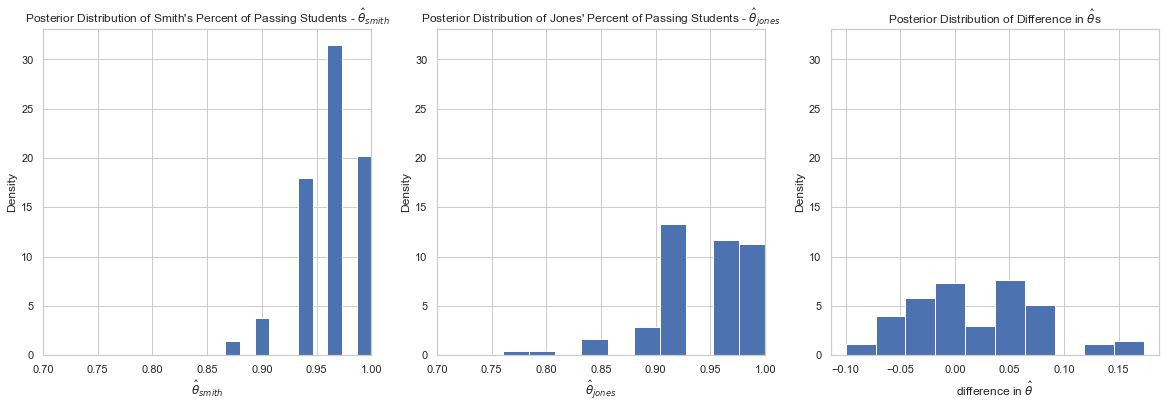

In [35]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

ax1 = figure.add_subplot(1, 3, 1)

ax1.hist( smith_pct_pass_posterior, density=True)
ax1.set_xlim(0.7, 1.0)
ax1.set_ylabel( "Density")
ax1.set_xlabel( "$\hat{\\theta}_{smith}$")
ax1.set_title( "Posterior Distribution of Smith's Percent of Passing Students - $\hat{\\theta}_{smith}$")

ax2 = figure.add_subplot(1, 3, 2, sharex = ax1, sharey = ax1)
ax2.hist( jones_pct_pass_posterior, density=True)
ax2.set_ylabel( "Density")
ax2.set_xlabel( "$\hat{\\theta}_{jones}$")
ax2.set_title( "Posterior Distribution of Jones' Percent of Passing Students - $\hat{\\theta}_{jones}$")

ax3 = figure.add_subplot(1, 3, 3, sharey = ax1)
ax3.hist( difference_posterior, density=True)
ax3.set_ylabel( "Density")
ax3.set_xlabel( "difference in $\hat{\\theta}$")
ax3.set_title( "Posterior Distribution of Difference in $\hat{\\theta}$s")

plt.show()
plt.close()

Before we interperet these plots, let's remember exactly what these $\hat{\theta}$s represent. They are the estimates of what percent of the class passes.

Now, we can say that it looks as if Mrs. Smith has a higher probability of all of the class passing, and at least 85% of her class will almost always pass. Whereas at least 75% of Mrs. Jones' class will almost always pass. 

Let's now use our definition of "equally effective"

In [36]:
(np.abs(difference_posterior) <= 0.05).mean()

0.64

Using the definition from Problem 4.1, there is a 64% probability that Mrs. Smith and Mrs. Jones are equally effective teachers.

### Problem 4.3

Answer one additional question of inference using the posterior distribution.

I'd like to know the probability that one teacher is better than the other, where "better" means "not-equal" using the equality definition from Problem 4.1.

In [37]:
smith_better = (difference_posterior > 0.05).mean()
jones_better = (difference_posterior < -0.05).mean()

print(f"The probability that Mrs. Smith is the better teacher is {100*smith_better:.1f}%")
print(f"The probability that Mrs. Jones is the better teacher is {100*jones_better:.1f}%")

The probability that Mrs. Smith is the better teacher is 22.0%
The probability that Mrs. Jones is the better teacher is 14.0%




---

**CHECK LIST**

Before you submit this assignent, go back and review the directions to ensure that you have followed each instruction.



*   Have you completed every section and answered every question asked?
*   For every question, have you described your approach and explained your results?
*   Have you checked for spelling and grammar errors?
*   Are your code blocks free of any errors?
*   Have you *SAVED* your notebook?

